# Deep Learning Project: Pet Classifier using CNN

Prepration
- Extract the ipynb file and the data in the same folder

Data Set
- A production grade program as 10,000 training images
- This is a small program with 20 images of cats and 20 images of dogs. 
- The evaluation set has 10 images of cats and 10 images of dogs

Runs
- The student is expected to run the 100-300 training step
- A production grade code would have about 20k-50k training steps

### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [6]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=2000 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 25986
X_data shape: (25986, 32, 32, 3)
y_data shape: (25986,)


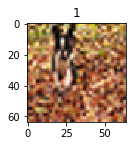

In [7]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy

Reading Material
- For ideas look at tensorflow layers tutorial

### The next cell should be removed before giving to students

In [9]:
def cnn_model_fn(features, labels, mode):
  #Model function for CNN.
  # Input Layer
  # Reshape X to 4-D tensor: [batch_size, width, height, channels]
  # PET Classifier images are 32*32*3 pixels, and have three color channel
  input_layer = tf.reshape(features["x"], [-1, 32, 32, 3])

# Convolutional Layer #1
  # Computes 32 features using a 5x5 filter with ReLU activation.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 32, 32, 3]
  # Output Tensor Shape: [batch_size, 32, 32, 32]
  conv1 = tf.layers.conv2d(
      inputs=input_layer,
      filters=32,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
    
# Pooling Layer #1
  # First max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 32, 32, 32]
  # Output Tensor Shape: [batch_size, 16, 16, 32]
  pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Convolutional Layer #2
  # Computes 64 features using a 5x5 filter.
  # Padding is added to preserve width and height.
  # Input Tensor Shape: [batch_size, 16, 16, 32]
  # Output Tensor Shape: [batch_size, 16, 16, 64]
  conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)
# Pooling Layer #2
  # Second max pooling layer with a 2x2 filter and stride of 2
  # Input Tensor Shape: [batch_size, 16, 16, 64]
  # Output Tensor Shape: [batch_size, 8, 8, 64]
  pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Flatten tensor into a batch of vectors
  # Input Tensor Shape: [batch_size, 8, 8, 64]
  # Output Tensor Shape: [batch_size, 8 * 8 * 64]
  pool2_flat = tf.reshape(pool2, [-1, 8 * 8 * 64])
    
# Dense Layer
  # Densely connected layer with 4096 neurons
  # Input Tensor Shape: [batch_size, 8 * 8 * 64]
  # Output Tensor Shape: [batch_size, 1024]
  dense = tf.layers.dense(inputs=pool2_flat, units=32, activation=tf.nn.relu)

# Add dropout probability 0f .4
  dropout = tf.layers.dropout(
      inputs=dense, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

# Logits layer
  # Input Tensor Shape: [batch_size, 32]
  # Output Tensor Shape: [batch_size, 10]
  logits = tf.layers.dense(inputs=dropout, units=2)
    
  predictions = {
      # Generate predictions (for PREDICT and EVAL mode)
      "classes": tf.argmax(input=logits, axis=1),
      # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
      # `logging_hook`.
      "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
  }
  if mode == tf.estimator.ModeKeys.PREDICT:
    return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

 # Calculate Loss (for both TRAIN and EVAL modes)
  loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

### Run the tensorflow model

This section will use the model defined by the student and run the training and evaluation step

In [ ]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="E:\ZeLab\Jupyter\Simplilearn\Second_Session\Projects (1)\pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_steps': None, '_task_id': 0, '_device_fn': None, '_train_distribute': None, '_log_step_count_steps': 100, '_save_checkpoints_secs': 600, '_evaluation_master': '', '_keep_checkpoint_every_n_hours': 10000, '_task_type': 'worker', '_tf_random_seed': None, '_num_ps_replicas': 0, '_is_chief': True, '_num_worker_replicas': 1, '_model_dir': 'E:\\ZeLab\\Jupyter\\Simplilearn\\Second_Session\\Projects (1)\\pets_convnet_model', '_keep_checkpoint_max': 5, '_service': None, '_session_config': None, '_global_id_in_cluster': 0, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x0000026D3CB23B38>, '_save_summary_steps': 100}
INFO:tensorflow:Calling model_fn.
pool2_flat (10, 4096)
dense shape (10, 1024)
dense  layer  Tensor("dense/Relu:0", shape=(10, 1024), dtype=float32)
logits shape (10, 2)
labels shape (10,)
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create 

INFO:tensorflow:loss = 1.52703e-05, step = 1201 (10.371 sec)
INFO:tensorflow:probabilities = [[ 0.00000117  0.99999881]
 [ 0.00001243  0.9999876 ]
 [ 0.00000004  1.        ]
 [ 0.00000016  0.99999988]
 [ 0.00000209  0.99999785]
 [ 0.00015777  0.99984217]
 [ 0.00004309  0.99995685]
 [ 0.00002513  0.99997485]
 [ 0.00047783  0.99952221]
 [ 0.00000339  0.99999666]] (5.139 sec)
INFO:tensorflow:global_step/sec: 9.75144
INFO:tensorflow:probabilities = [[ 0.00000347  0.99999654]
 [ 0.00007489  0.99992514]
 [ 0.0000031   0.9999969 ]
 [ 0.00003001  0.99996996]
 [ 0.00001103  0.99998891]
 [ 0.00000275  0.99999726]
 [ 0.00000169  0.99999833]
 [ 0.0000129   0.99998713]
 [ 0.00000553  0.99999452]
 [ 0.00004803  0.99995196]] (5.131 sec)
INFO:tensorflow:loss = 1.93353e-05, step = 1301 (10.271 sec)
INFO:tensorflow:probabilities = [[ 0.00000102  0.99999893]
 [ 0.00000002  1.        ]
 [ 0.0000004   0.99999964]
 [ 0.00001309  0.99998689]
 [ 0.00013487  0.99986506]
 [ 0.00000315  0.9999969 ]
 [ 0.00000016